In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV,RidgeCV,Lasso,Ridge
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.model_selection import train_test_split


In [2]:
df=pd.read_csv("insurance.csv")
datos=df.copy()
datos

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Preprocesamiento de datos

In [3]:
# Resumen de los datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
#Descripción de nuestra variable respuesta
datos['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [5]:
#Cantidad de categorías en las variables region y sexo
region=datos['region'].value_counts()
print(region)

sexo=datos['sex'].value_counts()
print(sexo)

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64
male      676
female    662
Name: sex, dtype: int64


In [6]:
# Calculemos la correlación de las variables, puesto que al tratar de utilizar la regresión L1, está caracteristica
#podría tener problemas

datos_numericos=datos.select_dtypes(include=['float64','int64'])
print(datos_numericos)
correlacion=datos_numericos.corr()['charges'][:-1]
corr_features=correlacion.sort_values(ascending=False)
corr_features #vemos que la correlación más alta es con respecto a la variable age, pero esta correlación no es significativa, no habrá problema al aplicar L1


      age     bmi  children      charges
0      19  27.900         0  16884.92400
1      18  33.770         1   1725.55230
2      28  33.000         3   4449.46200
3      33  22.705         0  21984.47061
4      32  28.880         0   3866.85520
...   ...     ...       ...          ...
1333   50  30.970         3  10600.54830
1334   18  31.920         0   2205.98080
1335   18  36.850         0   1629.83350
1336   21  25.800         0   2007.94500
1337   61  29.070         0  29141.36030

[1338 rows x 4 columns]


age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

/Users/jaangulor/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


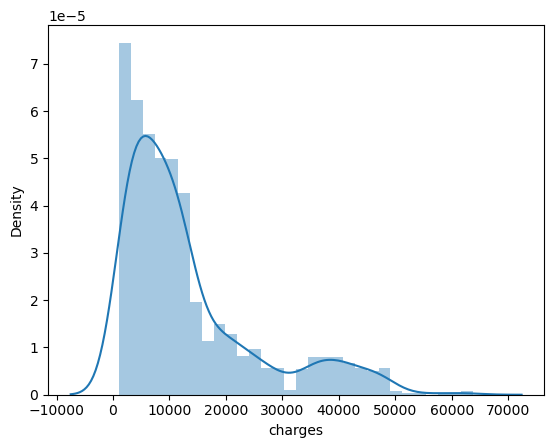

In [7]:
#Veamos la distribución de los datos para la variable respuesta, así sabremos sí hay que realizar una transformación o no
 #Los datos evidencian una gran cantidad de asimétria positiva, realizaremos una transformación logarítmica para tratar de corregir la asimetría. 
plot=sns.distplot(datos['charges'])

/Users/jaangulor/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


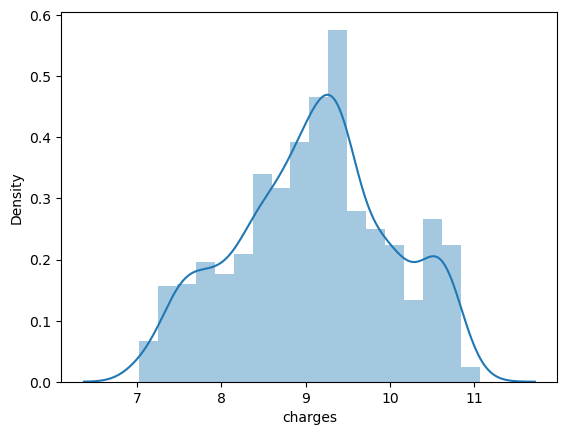

In [8]:
#La transfomación logró corregir el problema de simétria en la variable respuesta
trans_log=np.log(datos['charges'])
sns.distplot(trans_log)
datos['charges']=trans_log

In [9]:
# Ya que hemos realizado la transformación de la variable respuesta, tendremos que realizar de nuevo un análisis de correlación entre las variables explicativas y la variable respuesta

# Calculemos la correlación de las variables, puesto que al tratar de utilizar la regresión L1, está caracteristica
#podría tener problemas

datos_numericos=datos.select_dtypes(include=['float64','int64'])
correlacion=datos_numericos.corr()['charges'][:-1]
corr_features=correlacion.sort_values(ascending=False)
corr_features #vemos que la correlación más alta aumento con respecto a la variable age, pero esta correlación sigue siendo insignificante, no habrá problema al aplicar L1


age         0.527834
children    0.161336
bmi         0.132669
Name: charges, dtype: float64

In [10]:
# Decodificaremos los datos categoricos volviéndolos en variables dummy
datos= pd.get_dummies(datos,drop_first=True)
datos_2=datos.copy()
y_col='charges'
X=datos_2.drop(y_col,axis=1)
y=datos_2[y_col].copy()
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


In [11]:
# Dividimos nuestro conjunto de datos de entrenamiento(80%) y prueba(20%)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2)

# Modelos

## Modelo de regresión lineal

In [12]:
linear_r=LinearRegression()
linear_r.fit(X_train,y_train)
model_y_lr=linear_r.predict(X_test)
##Coeficientes de nuestro modelos de regresión líneal
pd.DataFrame(zip(X.columns,linear_r.coef_))

,0,1
0,age,0.034726
1,bmi,0.014125
2,children,0.097891
3,sex_male,-0.051287
4,smoker_yes,1.562762
5,region_northwest,-0.053446
6,region_southeast,-0.144435
7,region_southwest,-0.117372


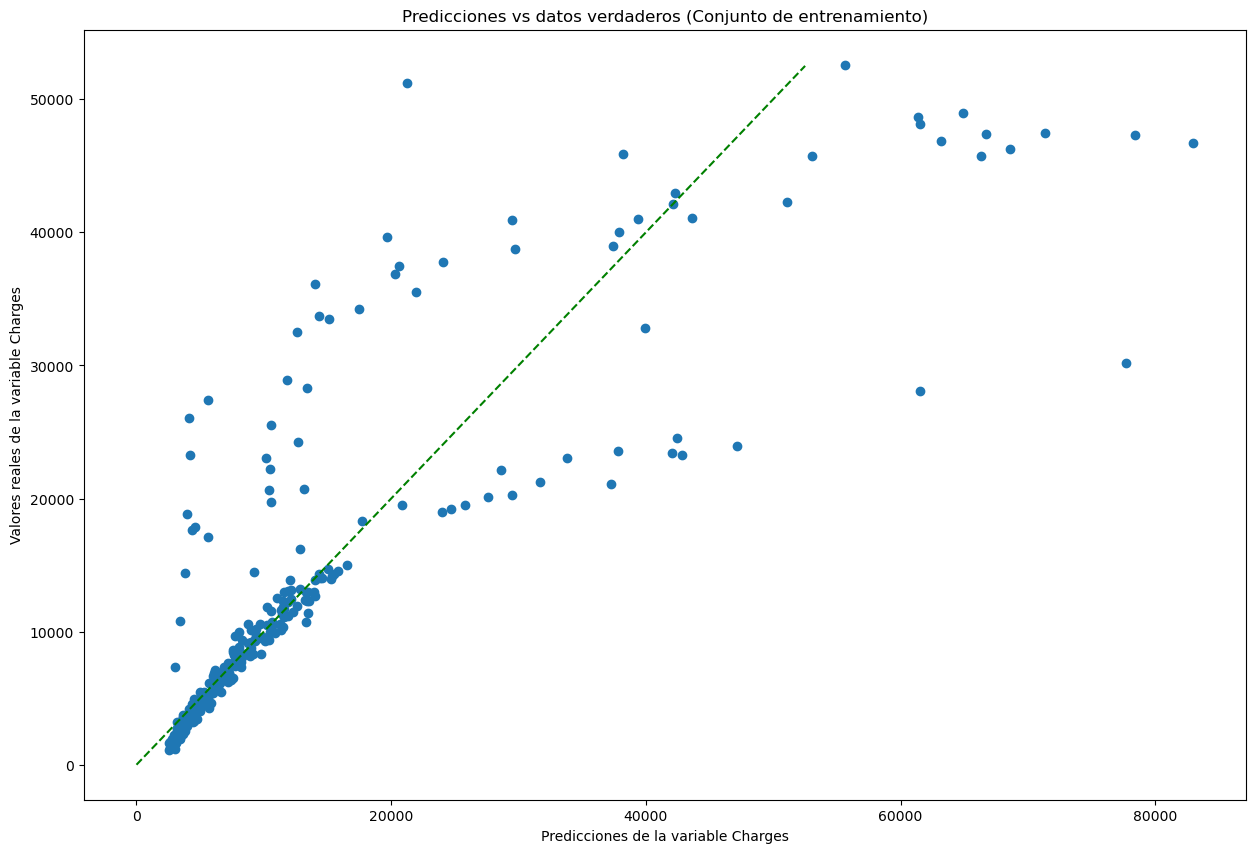

In [13]:
linea_reg=np.arange(2,np.exp(y_test).max(),500)
plt.figure(figsize=(15,10))
plt.plot(linea_reg,linea_reg,ls='--',color='green')
plt.scatter(x=np.exp(linear_r.predict(X_test)),y=np.exp(y_test))
plt.xlabel('Predicciones de la variable Charges')
plt.ylabel('Valores reales de la variable Charges')
plt.title('Predicciones vs datos verdaderos (Conjunto de entrenamiento)')
plt.show()

#Aunque al principio parece que el modelo se encuentra sobre ajustando, siendo capaz de predecir la mayoría de los datos
#parece que el modelo de regresión es capaz de generalizar bien la información


## Regresión polinomial

In [14]:
# Entrenamos el modelo de regresión polinomial con grados 1,2 y 3
X_train_poly = X_train.copy()
X_test_poly = X_test.copy()
y_train_poly = y_train.copy()
y_test_poly = y_test.copy()

model_score = []

for i in range(1,4):
    polyreg=make_pipeline(PolynomialFeatures(i,include_bias=True),LinearRegression())
    polyreg.fit(X_train_poly,y_train_poly)
    model_score.append(polyreg.score(X_train_poly,y_train_poly))

print(f'Score del modelo de entrenamiento: {model_score}')

Score del modelo de entrenamiento: [0.7620043923521438, 0.8262021259363699, 0.8433842642618491]


## Modelo Polinomial grado 1

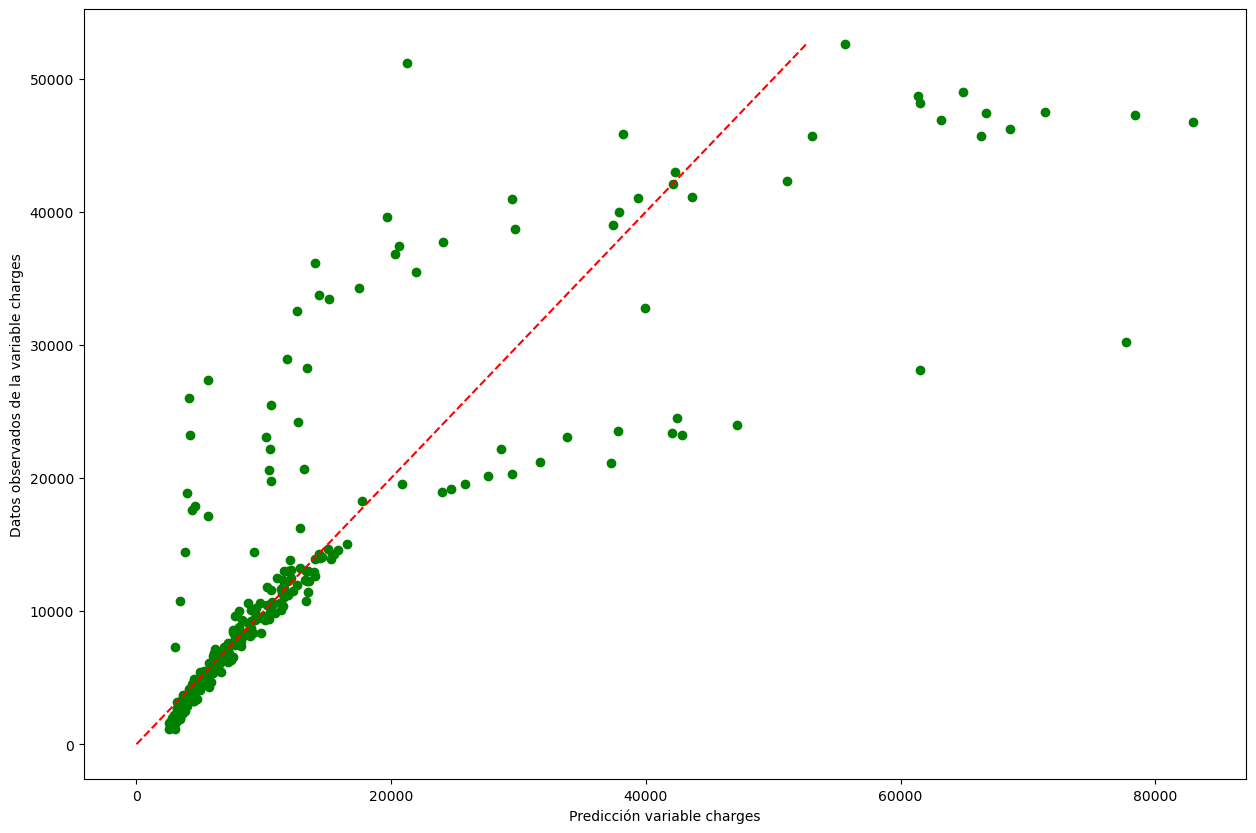

In [15]:
polyreg = make_pipeline(PolynomialFeatures(degree=1,include_bias=True),LinearRegression())
polyreg.fit(X_train_poly,y_train_poly)
y_pred_pr_1 = polyreg.predict(X_test_poly)
plt.figure(figsize=(15,10))
plt.scatter(np.exp(y_pred_pr_1),np.exp(y_test_poly),color='green')
plt.xlabel("Predicción variable charges") 
line = np.linspace(2,np.exp(y_test_poly).max(),500)
plt.plot(line,line,ls='--',color='red')
plt.ylabel("Datos observados de la variable charges")
plt.show()

## Modelo Polinomial grado 3

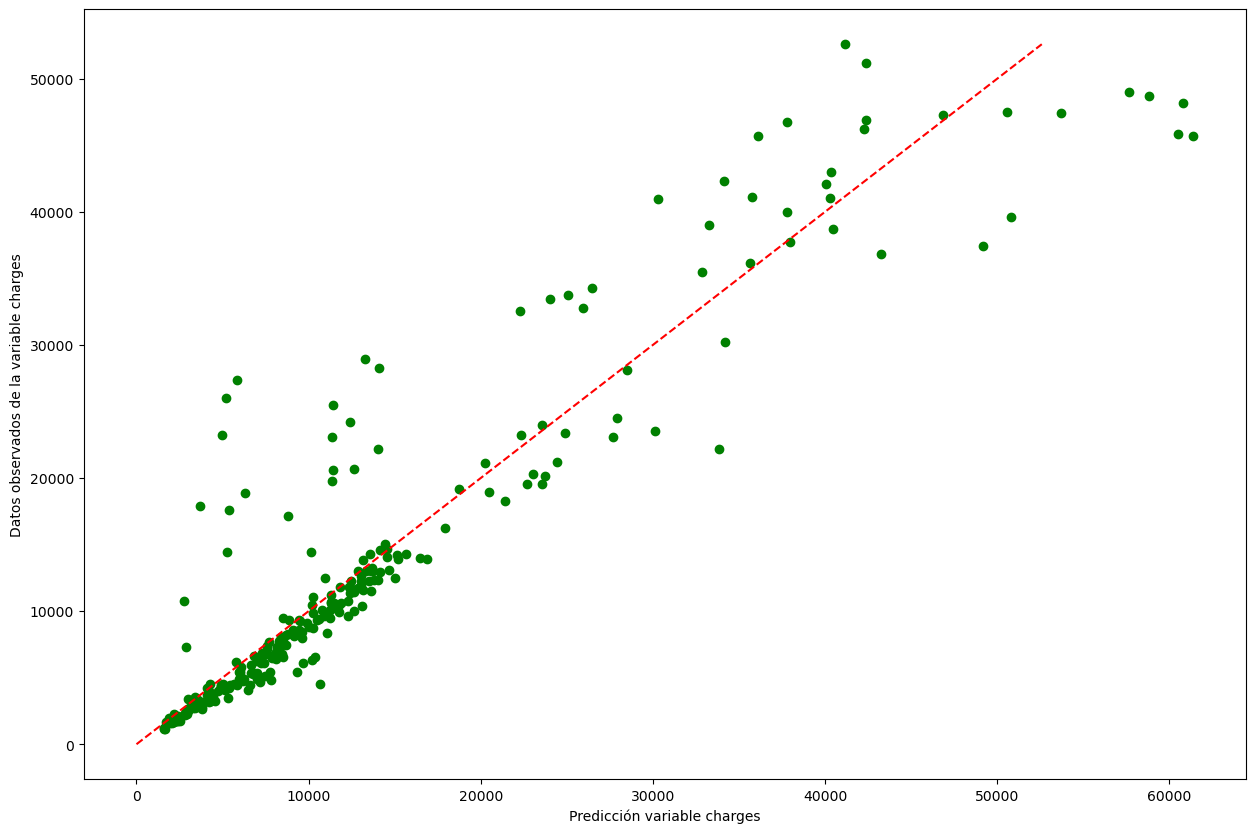

In [16]:
polyreg = make_pipeline(PolynomialFeatures(degree=3,include_bias=True),LinearRegression())
polyreg.fit(X_train_poly,y_train_poly)
y_pred_pr_3 = polyreg.predict(X_test_poly)
plt.figure(figsize=(15,10))
plt.scatter(np.exp(y_pred_pr_3),np.exp(y_test_poly),color='green')
plt.xlabel("Predicción variable charges") 
line = np.linspace(2,np.exp(y_test_poly).max(),500)
plt.plot(line,line,ls='--',color='red')
plt.ylabel("Datos observados de la variable charges")
plt.show()

## Regresión Ridge(L2)

In [17]:
# Regresión Ridge con parámetro alpha igual a 1.0, recordemos que debemos estandarizar antes de ejecutar el modelo
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

RR = Ridge(alpha=1.0)
RR.fit(x_train , y_train)
y_pred_ridge_1 = RR.predict(x_test)

RR.score(x_test,y_test)


0.790315759879667

/Users/jaangulor/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


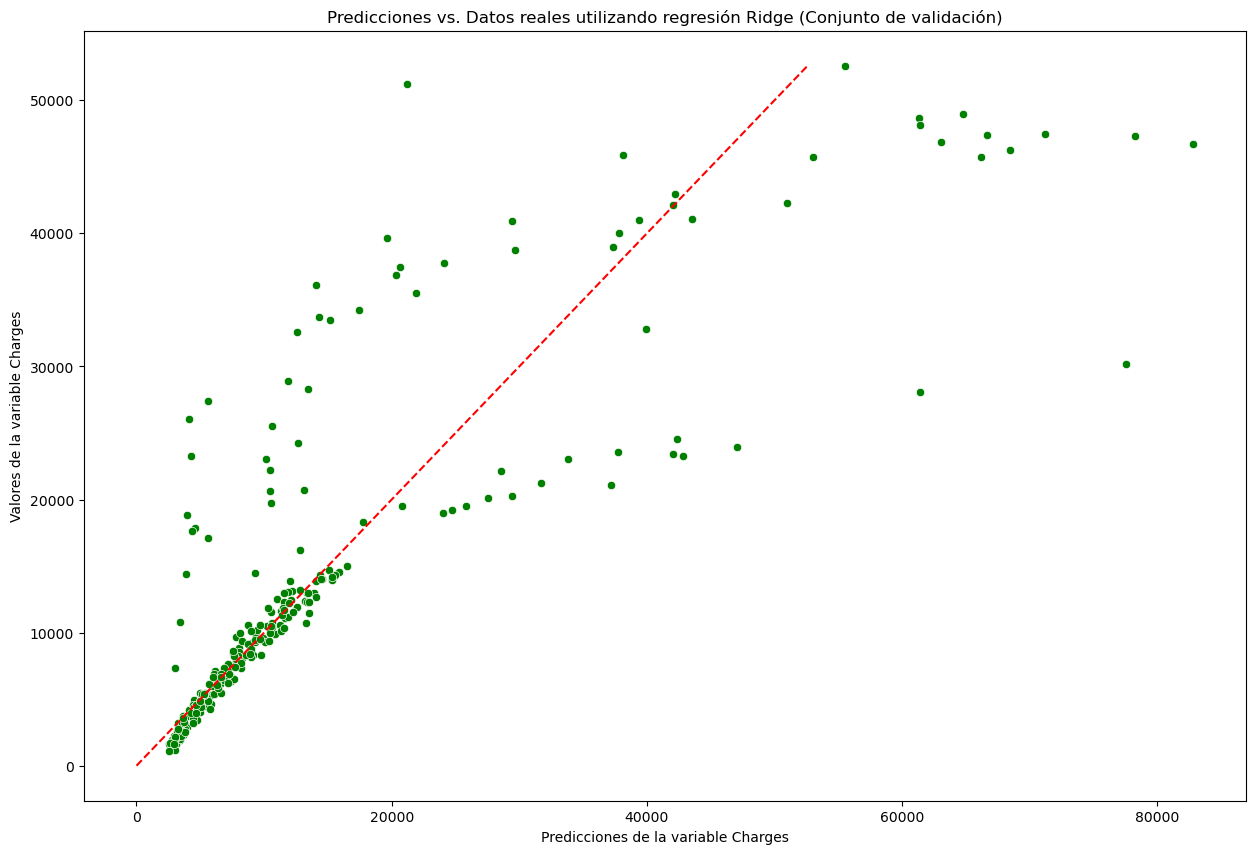

In [18]:
# Gráfico para los valores predichos vs datos actuales de validación, utilizando regresión Ridge con parámetro alpha =1.0

plt.figure(figsize=(15,10));
sns.scatterplot(np.exp(y_pred_ridge_1),np.exp(y_test),color='green');
plt.xlabel('Predicciones de la variable Charges')
plt.ylabel('Valores de la variable Charges')
plt.title('Predicciones vs. Datos reales utilizando regresión Ridge (Conjunto de validación)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

In [19]:
# Regresión Ridge con parámetro alpha igual a 0.5

RR = Ridge(alpha=0.5)
RR.fit(x_train , y_train)
y_pred_ridge_2 = RR.predict(x_test)

RR.score(x_test,y_test)

0.7903026960125743

/Users/jaangulor/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


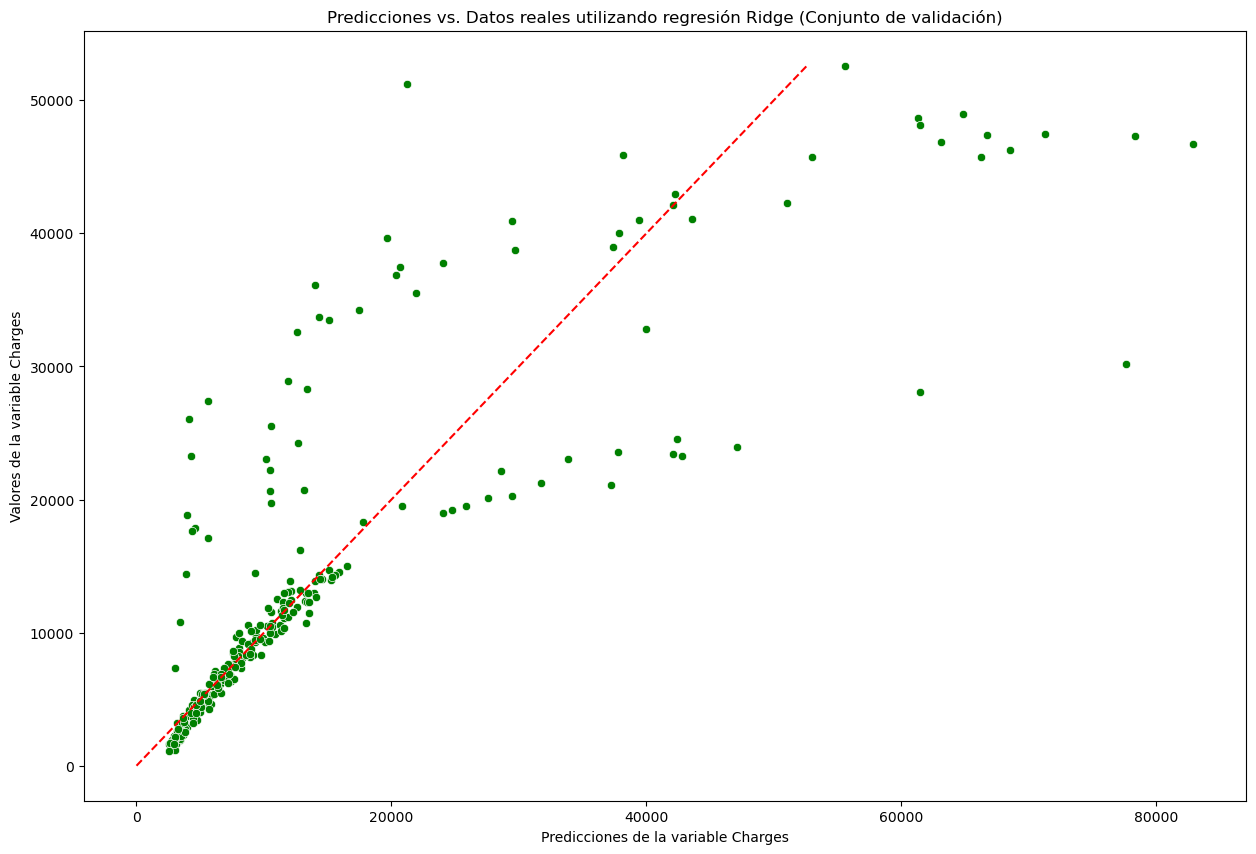

In [20]:
# Gráfico para los valores predichos vs datos actuales de validación, utilizando regresión Ridge con parámetro alpha =1.0

plt.figure(figsize=(15,10));
sns.scatterplot(np.exp(y_pred_ridge_2),np.exp(y_test),color='green');
plt.xlabel('Predicciones de la variable Charges')
plt.ylabel('Valores de la variable Charges')
plt.title('Predicciones vs. Datos reales utilizando regresión Ridge (Conjunto de validación)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

In [21]:
# Regresión Ridge con parámetro alpha igual a 0.1

RR = Ridge(alpha=0.1)
RR.fit(x_train , y_train)
y_pred_ridge_3 = RR.predict(x_test)

RR.score(x_test,y_test)

0.7902919576690319

/Users/jaangulor/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


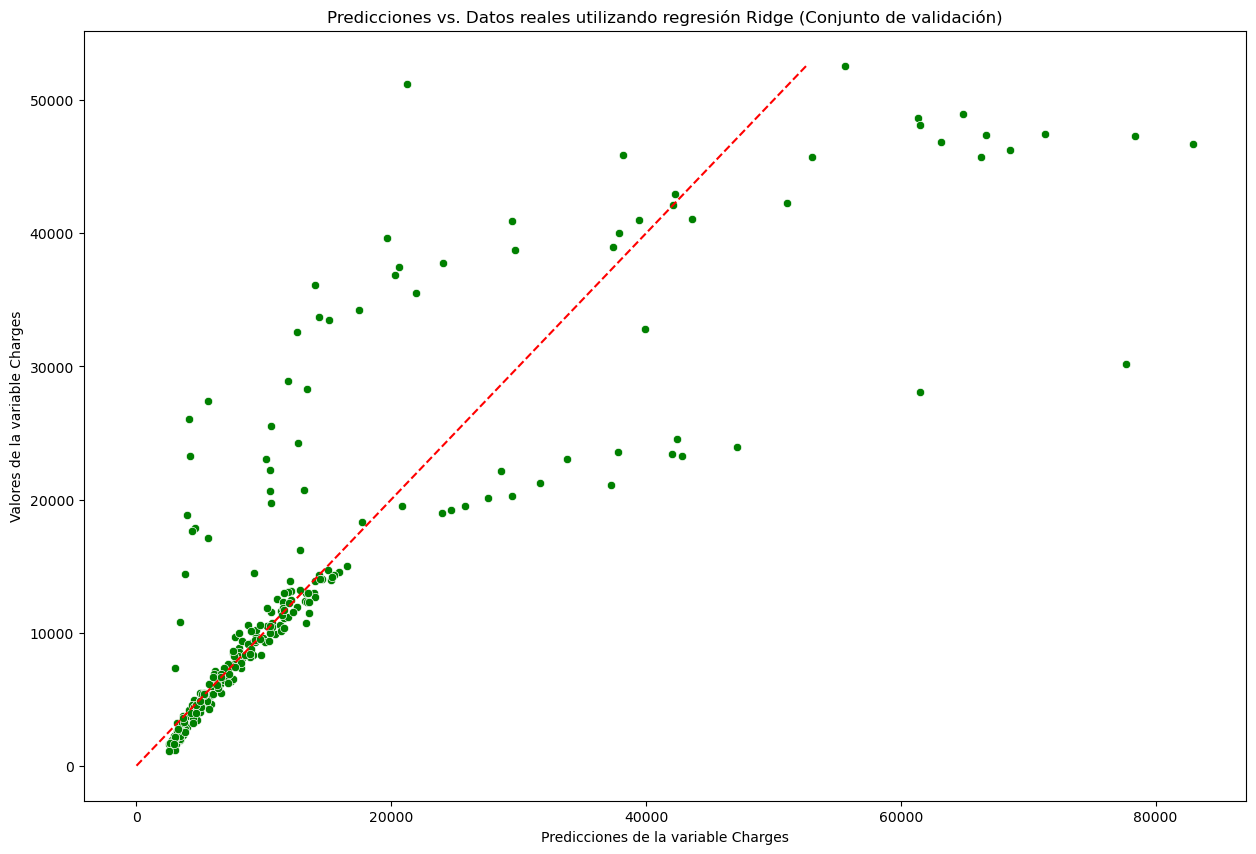

In [22]:
# Gráfico para los valores predichos vs datos actuales de validación, utilizando regresión Ridge con parámetro alpha =1.0

plt.figure(figsize=(15,10));
sns.scatterplot(np.exp(y_pred_ridge_3),np.exp(y_test),color='green');
plt.xlabel('Predicciones de la variable Charges')
plt.ylabel('Valores de la variable Charges')
plt.title('Predicciones vs. Datos reales utilizando regresión Ridge (Conjunto de validación)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

# Comparación y conclusiones del ejercicio

In [23]:
from sklearn.metrics import mean_squared_error,r2_score
def rmse(y_pred,y_test):
  return np.sqrt(mean_squared_error(y_pred,y_test))

## MSE y R2 PARA LA REGRESIÓN LÍNEAL SIMPLE

In [24]:
print('R2 score: ',r2_score(model_y_lr,y_test))
print('RMSE: ',rmse(model_y_lr,y_test))

R2 score:  0.7461354640371702
RMSE:  0.41965293507344864


## MSE Y R2 PARA LA REGRESIÓN POLINOMIAL GRADO 3

In [25]:
print('R2 score: ',r2_score(y_pred_pr_3,y_test))
print('RMSE: ',rmse(y_pred_pr_3,y_test))

R2 score:  0.8405781946320234
RMSE:  0.3345402565987695


## MSE Y R2 PARA LA REGRESIÓN RIDGE ALPHA=1.0

In [26]:
print('R2 score: ',r2_score(y_pred_ridge_1,y_test))
print('RMSE: ',rmse(y_pred_ridge_1,y_test))

R2 score:  0.7456768434118072
RMSE:  0.419626392828848


## a

i. ¿Es aceptable el error obtenido?

Como podemos notar en las métricas calculadas anteriormente, los errores en los 3 tipos de análisis que se realizaron son muy aceptables, siendo el error cuadrático medio del modelo polinómial de grado 3 el más bajo con respecto a los modelos de regresión líneal simple y regularización ridge con parámetro alpha 1.0.

ii. ¿Hay evidencia de overfitting?

No hay evidencia alguna de sobreajuste o subajuste en ninguno de los modelos.

## b

i. ¿Fue posible mejorar el error? ¿Qué hiper-parámetros tiene el modelo que produce el menor error?

Con el modelo de regresión polinómial fue posible reducir significativamente el error, teniendo en cuenta que el error cuadrático medio cálculado en el modelo de regresión líneal simple y de regularización Ridge, son muy similares. Los mejores hiper-parámetros también fueron los del modelo de regresión polinomial grado 3 y teniendo en cuenta el R2, estos hiper-parámetros se ajustan mucho mejor a la variable changes. Sin duda el modelo polinomial grado 3, es un modelo muy fiable para realizar futuras predicciones.

ii. ¿Qué atributos parecen ser los más importantes para realizar la predicción?

Sí la persona fuma o no fuma, el número de niños cubiertos por el seguro médico, la edad del beneficiario principal, el indice de masa corporal, parecen ser las variables más importantes para predecir los costos médicos del servicio de salud.